In [82]:
import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from train import load_model

from text import text_to_sequence

from utils import load_wav_to_torch
from scipy.io.wavfile import write
import os
import time

from sklearn.manifold import TSNE
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
import IPython.display as ipd
from tqdm import tqdm

In [83]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.max_decoder_steps = 1000

In [84]:
stft = TacotronSTFT(
            hparams.filter_length, hparams.hop_length, hparams.win_length,
            hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
            hparams.mel_fmax)

def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec

In [85]:
def plot_data(data, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    plt.imshow(data, aspect='auto', origin='bottom', interpolation='none')
#     plt.xlim(0,500)

## model load

In [86]:
checkpoint_path = "./outdir/soe/checkpoint_120000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

In [87]:
#waveglow_path = '/models/tacotron2-gst_waveglow_394000'
waveglow_name = "waveglow_model_628000"
waveglow_path = os.path.join("/home/zge/Work/Projects/evs/experiments/SpeechSynthesis/Tacotron2/synth_models", 
                               waveglow_name)
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda()

/home/zge/anaconda3/envs/jinhan-tacotron2-vae/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zge/anaconda3/envs/jinhan-tacotron2-vae/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zge/anaconda3/envs/jinhan-tacotron2-vae/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'glow.Invertible1x1Conv' has change

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
        (1): Conv1d(256, 512, k

## data load

In [88]:
path = './filelists/soe_test.txt'
with open(path, encoding='utf-8') as f:
    filepaths_and_text = [line.strip().split("|") for line in f]

In [89]:
model.eval()
prosody_outputs = []
emotions = []
mus = []
zs = []

for audio_path, _, _, emotion in tqdm(filepaths_and_text):
    melspec = load_mel(audio_path)
    prosody, mu, _, z = model.vae_gst(melspec)
    prosody_outputs.append(prosody.squeeze(1).cpu().data) 
    mus.append(mu.cpu().data)
    zs.append(z.cpu().data)
    emotions.append(int(emotion))
    
prosody_outputs = torch.cat(prosody_outputs, dim=0)
emotions = np.array(emotions) # list이면 안됨 -> ndarray
mus = torch.cat(mus, dim=0)
zs = torch.cat(zs, dim=0)

100%|██████████| 1468/1468 [00:09<00:00, 162.30it/s]


## Visualization

In [ ]:
print(emotions[:10])

In [90]:
# prepare data for scatter plot
colors = 'r','b','g','y'
labels = 'neutral','happy','angry','sad'

data_x = mus.data.numpy()
data_y = emotions

print(data_x.shape)
print(data_y.shape)

(1468, 32)
(1468,)


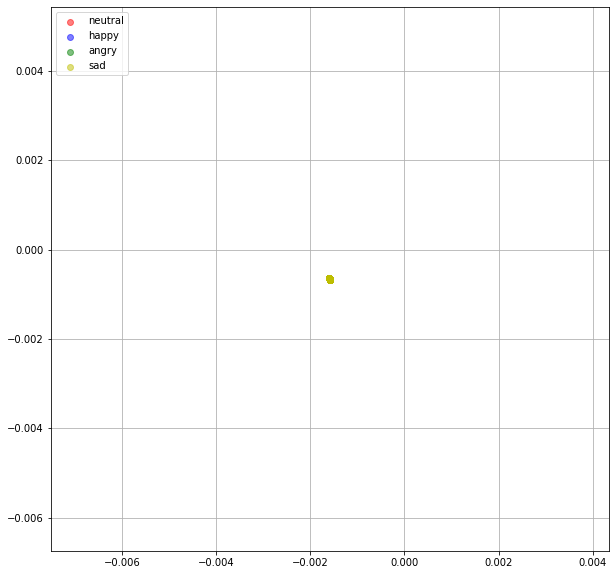

In [91]:
plt.figure(figsize=(10,10))
for i, (c, label) in enumerate(zip(colors, labels)):
    plt.scatter(data_x[data_y==i,0], data_x[data_y==i,1], c=c, label=label, alpha=0.5)

axes = plt.gca()
plt.grid(True)
plt.legend(loc='upper left')

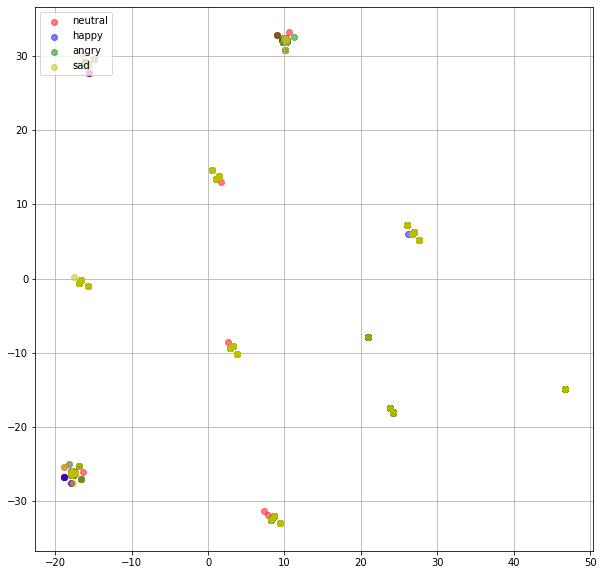

In [92]:
# t-SNE prosody
colors = 'r','b','g','y'
labels = 'neutral','happy','angry','sad'

data_x = mus.data.numpy()
data_y = emotions

tsne_model = TSNE(n_components=2, random_state=0, init='random')
tsne_all_data = tsne_model.fit_transform(data_x)
tsne_all_y_data = data_y

plt.figure(figsize=(10,10))
for i, (c, label) in enumerate(zip(colors, labels)):
    plt.scatter(tsne_all_data[tsne_all_y_data==i,0], tsne_all_data[tsne_all_y_data==i,1], c=c, label=label, alpha=0.5)

plt.grid(True)
plt.legend(loc='upper left')

## Text Encoder

In [93]:
def TextEncoder(text):
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
    inputs = model.parse_input(sequence)
    transcript_embedded_inputs = model.transcript_embedding(inputs).transpose(1,2)
    transcript_outputs = model.encoder.inference(transcript_embedded_inputs)
    return transcript_outputs

## Decoder

In [94]:
def Decoder(encoder_outputs):
    decoder_input = model.decoder.get_go_frame(encoder_outputs)
    model.decoder.initialize_decoder_states(encoder_outputs, mask=None)
    mel_outputs, gate_outputs, alignments = [], [], []

    while True:
        decoder_input = model.decoder.prenet(decoder_input)
        mel_output, gate_output, alignment = model.decoder.decode(decoder_input)

        mel_outputs += [mel_output]
        gate_outputs += [gate_output]
        alignments += [alignment]

        if torch.sigmoid(gate_output.data) > hparams.gate_threshold:
            # print(torch.sigmoid(gate_output.data), gate_output.data)
            break
        if len(mel_outputs) == hparams.max_decoder_steps:
            print("Warning! Reached max decoder steps")
            break

        decoder_input = mel_output

    mel_outputs, gate_outputs, alignments = model.decoder.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)
    mel_outputs_postnet = model.postnet(mel_outputs)
    mel_outputs_postnet = mel_outputs + mel_outputs_postnet

    with torch.no_grad():
        synth = waveglow.infer(mel_outputs, sigma=0.666)
        
    return synth, mel_outputs_postnet

## Interpolation

In [95]:
def generate_audio_vae(text, ref_audio, trg_audio, ratios):
    model.eval()
    
    transcript_outputs = TextEncoder(text)
    
    for ratio in ratios:
        latent_vector = ref_audio * ratio + trg_audio * (1.0-ratio)
        latent_vector = torch.FloatTensor(latent_vector).cuda()
        latent_vector = model.vae_gst.fc3(latent_vector)
       
        encoder_outputs = transcript_outputs + latent_vector

        synth, mel_outputs_postnet = Decoder(encoder_outputs)
        ipd.display(ipd.Audio(synth[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        #ipd.display(plot_data(mel_outputs_postnet.data.cpu().numpy()[0]))

In [96]:
# mean
# 0: neutral, 1: happy, 2: angry, 3: sad
encoded = zs.data.numpy()
neutral = np.mean(encoded[emotions==0,:], axis=0)
happy = np.mean(encoded[emotions==1,:], axis=0)
angry = np.mean(encoded[emotions==2,:], axis=0)
sad = np.mean(encoded[emotions==3,:], axis=0)

In [110]:
# neutral --> sad
#text = "I got a replacement phone and now all my text messages and call history are gone. I am sad." # sad
#text = "I have to watch it soon!" # happy
text = "This traffic is rediculous. I may not make it." # angry
ref_audio = neutral
trg_audio = angry
ratios = [1.0, 0.67, 0.33, 0.0]
generate_audio_vae(text, ref_audio, trg_audio, ratios)

In [101]:
text = "Today is such a wonderful day."
ref_audio = neutral
trg_audio = happy
ratios = [1.0, 0.67, 0.33, 0.0]
generate_audio_vae(text, ref_audio, trg_audio, ratios)

## Condition on Reference Audio

In [149]:
def generate_audio_vae_by_ref(text, ref_audio):
    model.eval()
    
    transcript_outputs = TextEncoder(text)
    
    print("reference audio")
    ipd.display(ipd.Audio(ref_audio, rate=hparams.sampling_rate))
    
    ref_audio_mel = load_mel(ref_audio)
    #ipd.display(plot_data(ref_audio_mel.data.cpu().numpy()[0]))
    
    latent_vector, mu, logvar, z = model.vae_gst(ref_audio_mel)
    latent_vector = latent_vector.unsqueeze(1).expand_as(transcript_outputs)

    encoder_outputs = transcript_outputs + latent_vector

    synth, mel_outputs = Decoder(encoder_outputs)
        
    ipd.display(ipd.Audio(synth[0].data.cpu().numpy(), rate=hparams.sampling_rate))
    #ipd.display(plot_data(mel_outputs.data.cpu().numpy()[0]))

reference audio


None

None

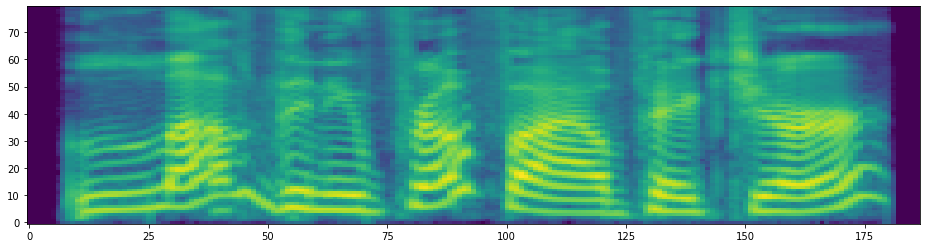

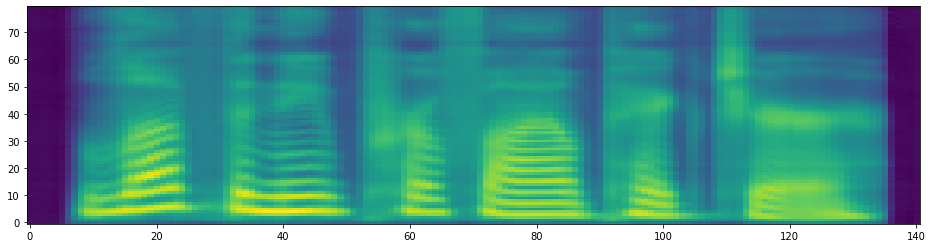

In [137]:
text = "Love the new profile picture!" # parallel
ref_wav = "data/SOE/renamed/F1/happy-extreme/F1-11-030269.wav"
generate_audio_vae_by_ref(text, ref_wav)

reference audio


None

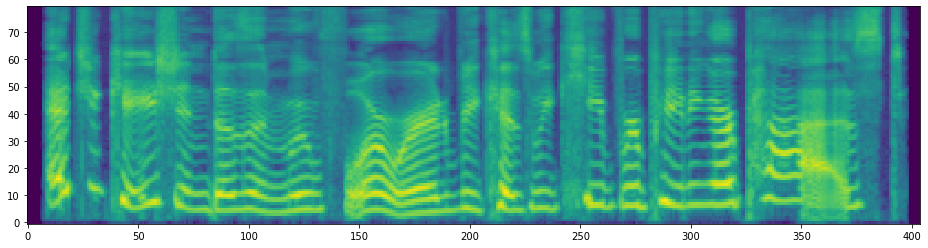

In [147]:
text = "Education doesn't move forward, because we keep repeating our past." # parallel
ref_wav = "data/SOE/renamed/F1/sad-extreme/F1-31-070052.wav"
generate_audio_vae_by_ref(text, ref_wav)

In [163]:
text = "Japan is a nation which is made up of many islands!"
#ref_wav = "data/SOE/renamed/F1/happy-extreme/F1-11-030397.wav"
ref_wav = "data/SOE/renamed/F1/happy-normal/F1-10-021311.wav"
generate_audio_vae_by_ref(text, ref_wav)

reference audio


In [167]:
text = "I wish I could stop crying, but I just can't. I miss him so much."
ref_wav = "data/SOE/renamed/F1/sad-normal/F1-30-060790.wav"
generate_audio_vae_by_ref(text, ref_wav)

reference audio


## Emotion label mixer

In [111]:
def generate_audio_vae_mix(text, ratios):
    model.eval()
    transcript_outputs = TextEncoder(text)
    
    latent_vector = ratios[0]*neu + ratios[1]*hap + ratios[2]*sad + ratios[3]*ang
    latent_vector = torch.FloatTensor(latent_vector).cuda()
    latent_vector = model.vae_gst.fc3(latent_vector)

    encoder_outputs = transcript_outputs + latent_vector

    synth, mel_outputs = Decoder(encoder_outputs)
        
    ipd.display(ipd.Audio(synth[0].data.cpu().numpy(), rate=hparams.sampling_rate))
    ipd.display(plot_data(mel_outputs.data.cpu().numpy()[0]))

None

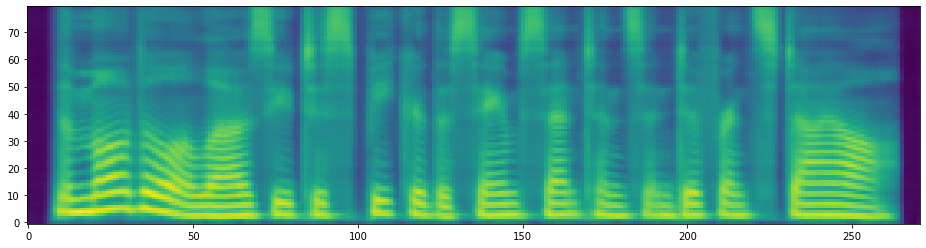

In [122]:
text = "The model allows you to speaker the same sentence in different style."
ratios = [0.0, 0.0, 1.0, 0.0] #neutral, happy, angry, sad
#ratios = [0.25, 0.25, 0.25, 0.25] #neutral, happy, angry, sad
generate_audio_vae_mix(text, ratios)